# NLP Disaster Tweets Kaggle Mini-Project

In [279]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from d2l import torch as d2l
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer,BertModel,BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [250]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

## Introduction

The objective of this project is to employ a deep learning algorithm for the purpose of predicting authentic disaster-related Tweets and distinguishing them from those that are not relevant to such incidents.

The data for this project includes a train.csv file, a test.csv file, and a sample_submission.csv file. The train.csv file contains 7613 samples, including information such as the text of tweets, keywords from tweets, the location that tweets were sent from, and targets that indicate whether the tweets refer to real disasters. Similarly, the test.csv file contains 3263 samples, with the same columns as the train.csv file, except no targets are included.


## Exploratory Data Analysis (EDA)

### Target Distribution

The training dataset contains 3271 positive samples, which means that 43% of the total images are positive (disaster). The target distribution is fairly even, so there is no need to implement any sampling strategies.

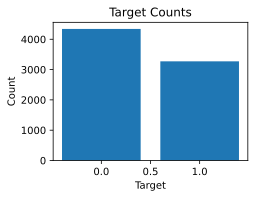

In [251]:
# Count the number of labels
counts = train_df['target'].value_counts()

# Plot the counts
plt.bar(counts.index, counts.values)

# Add labels and title
plt.title('Target Counts')
plt.xlabel('Target')
plt.ylabel('Count')

plt.show()

### Keyword Description

Analyzing the keywords in the training data can reveal the top 10 keywords associated with target 1. We identified that the top 5 keywords related to disasters in target 1 were derailment, wreckage, outbreak, debris, and oil spill. 

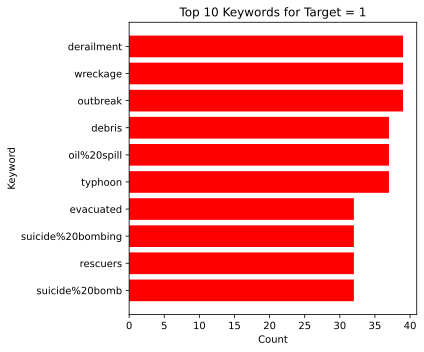

In [252]:
target1_df = train_df[train_df.target == 1]
top10_target1 = target1_df['keyword'].value_counts()[:10]
fig, ax = plt.subplots(figsize=(6, 5))
ax.barh(top10_target1.index, top10_target1.values, color='red')
ax.set_title('Top 10 Keywords for Target = 1')
ax.set_xlabel('Count')
ax.set_ylabel('Keyword')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

### Keyword Description

After plotting the top 10 locations, we discovered that the top 5 included USA, United States, Nigeria, India, and Mumbai. Nevertheless, we detected that city names like Washington, DC were also present in the plot, indicating the existence of dirty location data.

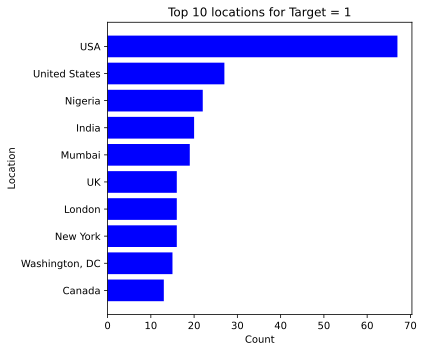

In [253]:
target1_df = train_df[train_df.target == 1]
top10_target1 = target1_df['location'].value_counts()[:10]
fig, ax = plt.subplots(figsize=(6, 5))
ax.barh(top10_target1.index, top10_target1.values, color='blue')
ax.set_title('Top 10 locations for Target = 1')
ax.set_xlabel('Count')
ax.set_ylabel('Location')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Data Cleaning

### Missing Values

We investigate the missing value problem in train and test datasets. 
It is shown in dataframe info that 
1. 0.8% of keywords is missing in both train and test datasets.
2. 33% of location is missing in both train and test datasets.

Since we will use NLP method to train models, so there is no need to process the missing values.
We will add the location and keywords in text for training and testing tasks.


In [254]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [255]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [256]:
train_df = train_df.fillna('')
test_df = test_df.fillna('')
train_df['text_all'] = train_df['location'] + train_df['keyword'] + train_df['text']
test_df['text_all'] = test_df['location'] + test_df['keyword'] + test_df['text']

### Text Clean

We have done some cleaning to the text, such as converting it to lowercase, removing all # and @ symbols, replacing all URL addresses with the string "URL", and replacing all non-alphanumeric characters, parentheses, question marks, exclamation marks, apostrophes, backticks, and double quotes with spaces.

In [257]:
def clean_text(text):
    text = str(text)
    text = text.lower() \
        .replace("#","") \
        .replace("http\S+","URL") \
        .replace("@","") \
        .replace("[^A-Za-z0-9()!?\'\`\"]", " ")
    return text

train_df['text_clean'] = train_df.text_all.map(lambda x: clean_text(x))
test_df['text_clean'] = test_df.text_all.map(lambda x: clean_text(x))

### Train data Split

Split the data into training and validation sets.

In [258]:
train_df, valid_df = train_test_split(train_df)

## Model Architecture

In this part, we train our models using BiRNN and Bert.

### BiRNN

BiRNN (Bidirectional Recurrent Neural Network) is a variant of Recurrent Neural Network (RNN) that can use both past and future data for prediction. It consists of two independent RNNs, one that processes data in a forward direction and another that processes data in a backward direction. The outputs of both networks are concatenated as the output of the BiRNN. This makes BiRNN suitable for sequence modeling tasks in natural language processing such as sequence labeling, sentiment analysis, and machine translation.

In [259]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs
    
## build vocabulary of dataset
train_tokens = d2l.tokenize(train_df.text_clean, token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

embed_size, num_hiddens, num_layers, devices = 100, 20, 2, d2l.try_all_gpus()
birnn_net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
                
birnn_net.apply(init_weights)
birnn_net

BiRNN(
  (embedding): Embedding(2252, 100)
  (encoder): LSTM(100, 20, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=80, out_features=2, bias=True)
)

### Bert

Bert model (Bidirectional Encoder Representations from Transformers) is a pre-trained language model developed by Google. It uses the transformer architecture, which is a type of neural network that is designed to process sequence data, such as text. Bert is pre-trained on large amounts of data to learn the context of words in a sentence, then fine-tuned on specific tasks such as text classification or question-answering. One of its unique features is that it is bidirectional, meaning it can take into account the context of a word both before and after it in a sentence, rather than just one direction. This makes it particularly effective for natural language processing tasks that require an understanding of semantics and word relationships. 

In [264]:
## load bert model from huggingface
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

class BERTClassifier(nn.Module):
    def __init__(self, bert_model,num_classes):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     token_type_ids=token_type_ids,
                                     return_dict=False)
        output = self.dropout(pooled_output)
        output = self.fc(output)
        return output


device = torch.device("cuda")
num_classes = 2

bert_net = BERTClassifier(bert_model,num_classes).to(device)
bert_net

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

## Result Analysis

Based on the training process below, we selected CrossEntropy as the loss function and Adam as the optimization method.
* The BiRNN model, with a learning rate of 0.01 and 10 epochs, exhibits severe overfitting, with a training accuracy of 0.95 and a test accuracy of only 0.74. However, with a learning rate of 0.01 and only 3 epochs, the BiRNN model achieves a test accuracy of 0.78.
* For the Bert model, with a learning rate of 1e-5 and 10 epochs, it achieves a test accuracy of 0.77, but also displays a significant overfitting problem. After reducing the number of epochs to 2, the Bert model is able to achieve a higher test accuracy of 0.801.


### BiRNN Training Result

#### Tokenization

To generate a vocabulary, we tokenize every word and eliminate the ones that appear less than 5 times in the training dataset.
After the tokenization phase, we plot a histogram to visualize the distribution of review lengths in terms of tokens.
As we anticipated, reviews have unique lengths. To handle minibatches of such reviews, we apply padding and truncation mechanisms to standardize the length of each review to 30 tokens.

In [265]:
train_tokens = d2l.tokenize(train_df.text_clean, token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

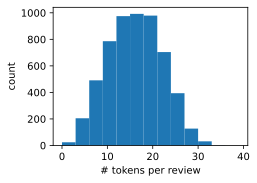

In [266]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 40, 3));

In [267]:
def load_data(batch_size, train_df, test_df, num_steps=30):
    train_tokens = d2l.tokenize(train_df['text_clean'], token='word')
    test_tokens = d2l.tokenize(test_df['text_clean'], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    print(train_features.shape)
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(list(train_df.target))),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(list(test_df.target))),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

batch_size = 16
train_iter, test_iter, vocab = load_data(batch_size, train_df, valid_df)

torch.Size([5709, 30])


loss 0.134, train acc 0.948, test acc 0.737
2298.4 examples/sec on [device(type='cuda', index=0)]


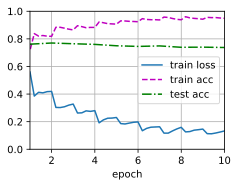

In [268]:
lr, num_epochs = 0.01, 10
trainer = torch.optim.Adam(birnn_net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(birnn_net, train_iter, test_iter, loss, trainer, num_epochs, d2l.try_all_gpus())

loss 0.241, train acc 0.900, test acc 0.780
2365.3 examples/sec on [device(type='cuda', index=0)]


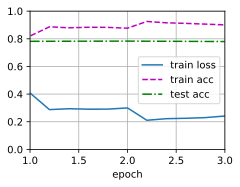

In [269]:
birnn_net.apply(init_weights)
lr, num_epochs = 0.01, 3
trainer = torch.optim.Adam(birnn_net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(birnn_net, train_iter, test_iter, loss, trainer, num_epochs, d2l.try_all_gpus())

### Bert 

#### dataset helper function

In [270]:
class BertDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        input_text = self.data.iloc[index]['text_clean']
        label = self.data.iloc[index]['target']
        
        encoding = self.tokenizer.encode_plus(
            input_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten()
        }, torch.tensor(label)
    
train_dataset = BertDataset(train_df, tokenizer, 20)
val_dataset = BertDataset(valid_df, tokenizer, 20)

In [271]:
train_iter = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_iter = DataLoader(val_dataset, batch_size=32, shuffle=False)

#### training helper function

In [272]:
def train_bert_batch(net, X, y, loss, trainer, device):
    inputs = {k: v.to(device) for k, v in X.items()}
    y = y.to(device)
    net.train()
    trainer.zero_grad()
    pred = net(**inputs)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum


def evaluate_accuracy(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()  
        if not device:
            device = next(iter(net.parameters())).device
    
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            inputs = {k: v.to(device) for k, v in X.items()}
            y = y.to(device)
            metric.add(d2l.accuracy(net(**inputs), y), d2l.size(y))
    return metric[0] / metric[1]


def train_bert(net, train_iter, test_iter, loss, trainer, num_epochs,device):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_bert_batch(
                net, features, labels, loss, trainer, device)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(device)}')

In [273]:
learning_rate = 1e-5
num_epochs = 10
batch_size = 32
device = torch.device("cuda")
num_classes = 2
optimizer = torch.optim.Adam(bert_net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

loss 0.002, train acc 0.979, test acc 0.777
351.2 examples/sec on cuda


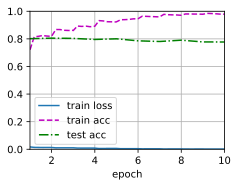

In [274]:
train_bert(bert_net,train_iter,test_iter,criterion,optimizer,num_epochs,device)

loss 0.013, train acc 0.822, test acc 0.801
352.3 examples/sec on cuda


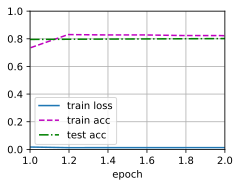

In [281]:
## init a new bert_net
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)
bert_net2 = BERTClassifier(bert_model,num_classes).to(device)

learning_rate = 1e-5
num_epochs = 2
batch_size = 32
device = torch.device("cuda")
num_classes = 2
optimizer = torch.optim.Adam(bert_net2.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_bert(bert_net2,train_iter,test_iter,criterion,optimizer,num_epochs,device)

In [282]:
torch.save(bert_net2.state_dict(), './bert_net2.pt')

## Kaggle Submission Predict

After submission, we achieve 0.79 score.

In [283]:
test_df['target'] = 0
len(test_df)

3263

In [284]:
testing_dataset = BertDataset(test_df, tokenizer, 20)
testing_iter = DataLoader(testing_dataset, batch_size=1, shuffle=False)

In [286]:
import numpy as np
from tqdm.notebook import trange, tqdm

def predict(net, data_iter, device=torch.device("cuda")):
    len_data = len(data_iter)
    y_out=torch.zeros(len_data,num_classes) 
    y_gt=np.zeros((len_data),dtype="uint8")
    
    if isinstance(net, nn.Module):
        net.eval()  
        if not device:
            device = next(iter(net.parameters())).device
            
    with torch.no_grad():
        i = 0
        for X, y in tqdm(data_iter):
            inputs = {k: v.to(device) for k, v in X.items()}
            y_out[i] = net(**inputs)
            i = i+1
    return y_out.numpy()

In [287]:
preds = predict(bert_net2, testing_iter, device=torch.device("cuda"))

  0%|          | 0/3263 [00:00<?, ?it/s]

In [297]:
preds_classes = np.argmax(preds,axis=1)
test_df['pred'] = preds_classes
result = test_df[['id','pred']]
result.columns = ['id','target']
result.to_csv("./submission.csv",index=False)

## Conclusion

In this project, we performed data cleaning and conducted exploratory data analysis on the disaster tweets dataset. Using the PyTorch, D2L, and transformers libraries, we built and trained models, trying out different architectures and hyperparameters to find the optimal model. We addressed the issue of overfitting in our models. After submission, our Bert-based model achieved a score of 0.79. Applying a pre-trained model improved our performance, although the fine-tuning of such models requires significant computational resources, and their cost-effectiveness must be carefully considered in practical applications.

For future work, we can consider trying the Bert model with alternative optimization methods and loss functions. Additionally, we could explore using other advanced pre-trained models to solve this problem.